<a href="https://colab.research.google.com/github/anushapatil5/NLU-ContentModeration/blob/master/Baseline_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving modlog.csv to modlog.csv


In [2]:
import io
import pandas as pd
import numpy as np

df = pd.read_csv(io.BytesIO(uploaded['modlog.csv']))
df.head(5)

,Mod_Name,Removal_Reason,Text,Action
0,airtmac24,unspam,all the players kind of hate him so no one sai...,approvecomment
1,f1uk3r,confirm_ham,"it's been a wild 24 hours for the bulls, i can...",approvecomment
2,f1uk3r,confirm_ham,Here let me get this utterly brave comment tha...,approvecomment
3,IamOlderthanMe,unspam,We need to come together to help those in need...,approvecomment
4,jadenx2,confirm_ham,**EVERYONE GET IN HERE**\n\n\nEdit: [Live look...,approvecomment


In [3]:
df2 = df.replace("approvecomment", 1)
df2 = df2.replace("removecomment", 0)
df2 = df2.drop(['Removal_Reason'], axis = 1)
df2 = df2.drop(['Mod_Name'], axis = 1)
df = df2
df.head()

,Text,Action
0,all the players kind of hate him so no one sai...,1
1,"it's been a wild 24 hours for the bulls, i can...",1
2,Here let me get this utterly brave comment tha...,1
3,We need to come together to help those in need...,1
4,**EVERYONE GET IN HERE**\n\n\nEdit: [Live look...,1


In [4]:
df.shape[0]

13656

In [5]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.Text), list(train_df.Action)
val_texts, val_labels     = list(val_df.Text), list(val_df.Action)
test_texts, test_labels   = list(test_df.Text), list(test_df.Action)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 13656
Train size: 9560
Val size: 2048
Test size: 2048



In [6]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2020-04-21 17:02:33--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 74.125.142.101, 74.125.142.138, 74.125.142.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u51jgcgto9m0htdmar3s0637i51qhqq0/1587488550000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2020-04-21 17:02:38--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u51jgcgto9m0htdmar3s0637i51qhqq0/1587488550000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|74.125.142.

In [0]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM=300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

In [0]:
vocab_size = len(vocab)

In [26]:
vocab_size

50002

In [10]:
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
import tqdm

     |████████████████████████████████| 890kB 5.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=8bba567367e6ab08255d992f0b1ba82192d665bad69c1279a83c36a7d56f6726
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [11]:
def featurize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm.tqdm_notebook(data):
        tokenized = tokenizer.tokenize(ex) #removing ex.lower()
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = featurize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = featurize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = featurize(test_texts, test_labels, tokenizer, vocab)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [0]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def spam_collate_func(self,batch):
        
        data_text = [i[0] for i in batch]
        target = [i[1] for i in batch]

        data_list = [] # store padded sequences
        label_list = target
        lengths = []
        

        #max_batch_seq_len = None # the length of longest sequence in batch
                                 # if it is less than self.max_sent_length
                                 # else max_batch_seq_len = self.max_sent_length
        for data in data_text:
            lengths.append(len(data))

        if self.max_sent_length > max(lengths):
          max_batch_seq_len = self.max_sent_length
        else:
          max_batch_seq_len = max(lengths)

      
        

        for i, data in enumerate(data_text):
            if len(data) < max_batch_seq_len:
              data_list.append(data)
              data_list[i].extend([0] * (max_batch_seq_len - len(data)))
              #data_list.append(temp[i])
            
            elif len(data) > self.max_sent_length:
              data_list.append(data[:self.max_sent_length])
              #data_list[i].append(temp[i])
            
            elif len(data) == self.max_sent_length:
              data_list.append(data)
              #data_list[i].append(temp[i])

        

        return torch.as_tensor(data_list), torch.as_tensor(label_list)

BATCH_SIZE = 100 #[64]
max_sent_length=256 #[128]
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)



In [34]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([100, 256])
data_batch:  tensor([[    1,  1831,     2,  ...,     0,     0,     0],
        [    1, 11837,   194,  ...,     0,     0,     0],
        [    1,     1,    83,  ...,     0,     0,     0],
        ...,
        [    1,  2768,     4,  ...,     0,     0,     0],
        [    1,   740, 10576,  ...,     0,     0,     0],
        [    1,  3318,  3073,  ...,     0,     0,     0]])
labels:  tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 0])


In [0]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [0]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F



class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(self.embedding_layer.embedding_dim, hidden_size, num_layers, dropout = dropout_prob, batch_first=True) # change this for hyperparameter tuning
        batch_first = True
        self.non_linearity = None # For example, ReLU
        self.clf = nn.Linear(hidden_size, num_classes) # classifier layer change this
        self.out_layer = nn.Linear(self.embedding_layer.embedding_dim, num_classes)
        self.sig = nn.Sigmoid()
       
        pass
    
    def load_pretrained_embeddings(self, embeddings):
        
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer


    def forward(self, x):
        logits = None

        

        # Retrieve embedding vector for each token
        # Output dim: [batch_size, seq_length, embedding_dim]
        embedded = self.embedding_layer(x)
        
        # Compute the number of valid (non-padding, non-unknown) embeddings per exmaple
        # Output dim: [batch_size]
        num_embedded = (x != self.embedding_layer.padding_idx).float().sum(dim=1).clamp(1)
        
        # Average the embeddings for each example
        # Output dim: [batch_size, embedding_dim]
        averaged_embeddings = embedded.sum(dim=1) / num_embedded.view(-1, 1)
        
        # Put the embedding through a linear layer to get our score (logit)
        #   for each class
        out = self.out_layer(averaged_embeddings)
        out = F.relu(out)
        logits = self.sig(out)
     
        return logits
   

In [0]:
def evaluate(model, dataloader, device):
    accuracy = None
    count = 0
    model.eval()
    
    with torch.no_grad():
        all_preds = []
        for batch_text, batch_labels in dataloader:
            preds = model(batch_text.to(device))
            pred = preds.argmax(dim=1, keepdim=True)

            count += pred.eq(batch_labels.view_as(pred)).sum().item()



    accuracy = count / len(dataloader.dataset)
    
    return accuracy 

In [37]:
# BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional=True
torch.manual_seed(1234)

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device=torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [17]:
train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2
NUM_EPOCHS=5


  
for epoch in tqdm.tqdm_notebook(range(NUM_EPOCHS)):
    model.train() # this enables regularization, which we don't currently have
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device))
        loss = criterion(preds, batch_labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_history.append(loss.item())
    val_accuracy_history.append(evaluate(model, val_loader, device))
    best_val_accuracy = max(val_accuracy_history)

    if val_accuracy_history[epoch] == best_val_accuracy:
      torch.save(model, 'best_model.pt')

    else:
      n_no_improve +=1

    if n_no_improve == early_stop_patience:
       break
  
        
    # The end of a training epoch     

print("Best validation accuracy is: ", best_val_accuracy) #2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LSTMClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Best validation accuracy is:  0.74658203125


In [18]:
val_accuracy_history

[0.744140625, 0.74560546875, 0.74658203125, 0.73876953125, 0.7265625]

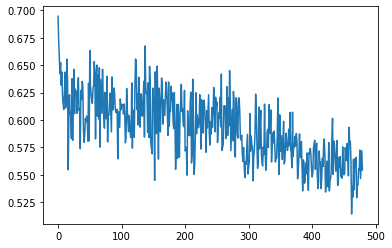

In [40]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

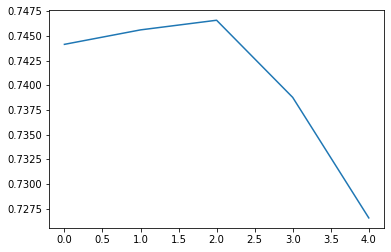

In [41]:
pd.Series(val_accuracy_history).plot()

In [42]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader, device)
#test_accuracy = 
print(test_accuracy)

0.73486328125


In [0]:
from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()

X_train = v.fit_transform(train_df['Text'].apply(lambda x: np.str_(x)))
X_val = v.fit_transform(val_df['Text'].apply(lambda x: np.str_(x)))
X_test = v.fit_transform(test_df['Text'].apply(lambda x: np.str_(x)))
y_train = train_labels
y_val = val_labels
y_test = test_labels 

In [0]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_val, y_val)

print("Accuracy:", score)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: ignored

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tk = Tokenizer()
tk.fit_on_texts(texts)
index_list = tk.texts_to_sequences(texts)
x_train = pad_sequences(index_list, maxlen=maxlen)

In [44]:
from keras.models import Sequential
from keras import layers
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [53]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=6477))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 6477, 50)          2500100   
_________________________________________________________________
flatten_3 (Flatten)          (None, 323850)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                3238510   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 5,738,621
Trainable params: 5,738,621
Non-trainable params: 0
_________________________________________________________________


In [56]:
X_train.shape

(9560, 14939)

In [54]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_val, y_val),
                    batch_size=100)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

ValueError: ignored